In [1]:
#Importing all the libraries here
import numpy as np
import os
import pyvista as pv
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
pv.set_jupyter_backend('trame')

In [2]:
#load manual data 

for i in range(30):
    FileName : str = f"DAM/{i}TestData2.csv"
    MData = pd.read_csv(FileName)
    #print(MData.head())
    MData_array = []
    for j in range(len(MData['X'])):
        vector = (MData['X'][j], MData['Y'][j],MData['Z'][j])
        MData_array.append(vector)
#base compare dataset    
MData_set = set(MData_array)

In [3]:
#Reading in all the folders from the run
DataAnalysisFolder = "C:\\Users\\Jason\\Documents\\SChool\\research\\go-explore\\Data"

os.chdir(DataAnalysisFolder)
# Print the current working directory to confirm the change
print("Current working directory:", os.getcwd())

# List all files and folders in the directory
file_list = os.listdir(DataAnalysisFolder)
print("number of current folders is", len(file_list))

# Filter out only the directories
folders = [item for item in file_list if os.path.isdir(os.path.join(DataAnalysisFolder, item))]
print("Folders within the specified directory:")
for folder in folders:
    print(folder)

# Get full paths for all the files within the folder
full_paths = [os.path.join(DataAnalysisFolder, file) for file in file_list]
print(full_paths)

####################################################################
num_minutes = 60 #change however you want. 
TimeLine = np.arange(0,30,1) #for plotting
TimeLine2 = np.arange(0,60,1)
TimeLine3 = np.arange(0,120,1)
RediscoveryRate = {} 
FCRR = {}
Vanilla2 = {}

####################################################################


Current working directory: C:\Users\Jason\Documents\SChool\research\go-explore\Data
number of current folders is 19
Folders within the specified directory:
BestCombination
BestCombination2
Vanilla100seed
Vanilla10TimeDilation
Vanilla2TimeDilation
Vanilla50seed
Vanilla5TimeDilation
VanillaBrownian
VanillaGoExplore
VanillaGoExplore2
VanillaHeuristic
VanillaStateful
['C:\\Users\\Jason\\Documents\\SChool\\research\\go-explore\\Data\\Best Combination Comparison.pdf', 'C:\\Users\\Jason\\Documents\\SChool\\research\\go-explore\\Data\\BestCombination', 'C:\\Users\\Jason\\Documents\\SChool\\research\\go-explore\\Data\\BestCombination2', 'C:\\Users\\Jason\\Documents\\SChool\\research\\go-explore\\Data\\Cell Heuristic Comparison.pdf', 'C:\\Users\\Jason\\Documents\\SChool\\research\\go-explore\\Data\\Combined.csv', 'C:\\Users\\Jason\\Documents\\SChool\\research\\go-explore\\Data\\Input Strategy Comparison.pdf', 'C:\\Users\\Jason\\Documents\\SChool\\research\\go-explore\\Data\\Navmesh Seeding Compa

In [4]:
from concurrent.futures import ThreadPoolExecutor
# Function to process each session
def process_session(session_path, num_minutes, MData_set, MData_array):
    rates = []
    for i in range(num_minutes):
        csv_path = f"{session_path}/Minute{i}.csv"
        instance = pd.read_csv(csv_path)
        
        # Convert the X, Y, Z columns to tuples more efficiently
        data = set(zip(instance['X'], instance['Y'], instance['Z']))

        # Compute intersection with MData_set
        combined = MData_set & data
        rate = len(combined) / len(MData_array) if len(MData_array) > 0 else 0
        rates.append(rate)

    return session_path, np.array(rates)


# Using parallel processing to speed up file I/O and computations
def process_folders(folders, num_minutes, MData_set, MData_array):
    RediscoveryRate = {}

    with ThreadPoolExecutor() as executor:
        # Iterate over each folder
        futures = []
        for folder in tqdm(folders):
            for session in os.listdir(folder):
                session_path = os.path.join(folder, session)
                if os.path.isdir(session_path):
                    # Submit session processing to thread pool
                    futures.append(executor.submit(process_session, session_path, num_minutes, MData_set, MData_array))
        
        # Collect the results
        for future in tqdm(futures):
            session_path, rates = future.result()
            RediscoveryRate[session_path] = rates

    return RediscoveryRate

# Example call
RediscoveryRate = process_folders(folders, num_minutes, MData_set, MData_array)
FCRR = process_folders([folders[1]], 120, MData_set, MData_array)
Vanilla2 = process_folders([folders[9]], 120, MData_set, MData_array)




  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
def process_CSV(session_path, num_minutes, MData_set):
    final_array = []
    csv_path = f"{session_path}/Minute{60}.csv"
    instance = pd.read_csv(csv_path)
    # Convert the X, Y, Z columns to tuples more efficiently
    data = set(zip(instance['X'], instance['Y'], instance['Z']))

        # Compute intersection with MData_set
    combined = list(MData_set & data)
# Find unique values in each array
    MData_unique = list(MData_set - data)
    Data_unique = list(data - MData_set)
    df = pd.DataFrame(list(combined), columns=['X', 'Y', 'Z'])
    df2 = pd.DataFrame(list(MData_unique), columns=['X', 'Y', 'Z'])
    df3 = pd.DataFrame(list(Data_unique), columns=['X', 'Y', 'Z'])
    df['InputStrategy'] = 'Both'
    df2['InputStrategy'] = 'Manual'
    df3['InputStrategy'] = 'Go-Explore'
    cdf = pd.concat([df, df2,df3], ignore_index=True)
    print(cdf.head())
    return cdf


In [6]:
# Assuming the variables `folders`, `num_minutes`, `MData_set`, and `MData_array` are defined

# Process the first folder with the `process_CSV` function
if folders:
    first_folder = folders[0]
    first_session = os.listdir(first_folder)[0]
    first_session_path = os.path.join(first_folder, first_session)
    
    if os.path.isdir(first_session_path):
        combined_df = process_CSV(first_session_path, num_minutes, MData_set)
        print("Combined DataFrame for the first folder:")
        print(combined_df.head())
        combined_df.to_csv('Combined.csv', index=True)




    X   Y   Z InputStrategy
0 -11 -18   2          Both
1   5 -19   9          Both
2  11  18  11          Both
3  -2 -24   2          Both
4  -1 -24   2          Both
Combined DataFrame for the first folder:
    X   Y   Z InputStrategy
0 -11 -18   2          Both
1   5 -19   9          Both
2  11  18  11          Both
3  -2 -24   2          Both
4  -1 -24   2          Both


# Cell Selection Heuristic Comparison


dict_keys(['BestCombination\\BestC', 'BestCombination\\BestC2', 'BestCombination\\BestC3', 'BestCombination2\\Instance_14768_true_5_100_S_1.0', 'BestCombination2\\Instance_43464_true_5_100_S_1.0', 'BestCombination2\\Instance_49280_true_5_100_S_1.0', 'Vanilla100seed\\Vanilla100seed', 'Vanilla100seed\\Vanilla100seed2', 'Vanilla100seed\\Vanilla100seed3', 'Vanilla10TimeDilation\\Vanilla10TD', 'Vanilla10TimeDilation\\Vanilla10TD2', 'Vanilla10TimeDilation\\Vanilla10TD3', 'Vanilla2TimeDilation\\Vanilla2TD', 'Vanilla2TimeDilation\\Vanilla2TD2', 'Vanilla2TimeDilation\\Vanilla2TD3', 'Vanilla50seed\\Vanilla50seed', 'Vanilla50seed\\Vanilla50seed2', 'Vanilla50seed\\Vanilla50seed3', 'Vanilla5TimeDilation\\Vanilla5TD', 'Vanilla5TimeDilation\\Vanilla5TD2', 'Vanilla5TimeDilation\\Vanilla5TD3', 'VanillaBrownian\\VanillaBrownian2', 'VanillaBrownian\\VanillaBrownian3', 'VanillaBrownian\\VanillaBrowninan', 'VanillaGoExplore\\VanillaGo-Explore', 'VanillaGoExplore\\VanillaGo-Explore2', 'VanillaGoExplore\\Van

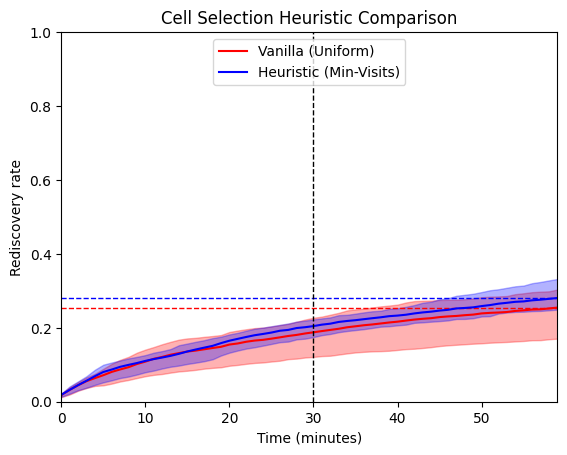

In [7]:
print(RediscoveryRate.keys())
keys = list(RediscoveryRate.keys())
print(len(keys))

RRD = {}

for i in range(0,len(keys), 3):
    stacked = np.stack([np.array(RediscoveryRate[keys[i]]),np.array(RediscoveryRate[keys[i+1]]),np.array(RediscoveryRate[keys[i+2]])])
    max_vals = np.max(stacked, axis=0)
    min_vals = np.min(stacked, axis=0)
    mean_vals = np.mean(stacked, axis=0)

    upper_error = max_vals - mean_vals
    lower_error = mean_vals - min_vals
    errors = [lower_error, upper_error]

    RRD[keys[i]] = [mean_vals, errors,  min_vals, max_vals]
    
new_keys = list(RRD.keys())
print(new_keys)


selected_index = [(8, "Vanilla (Uniform)", 'red'),
                  (9, "Heuristic (Min-Visits)", 'blue')]

for i, label, color in selected_index:
    plt.fill_between(TimeLine2, RRD[new_keys[i]][2], RRD[new_keys[i]][3] , color = color, alpha = 0.3)
    plt.plot(TimeLine2, RRD[new_keys[i]][0], color = color, label = label)
    #plt.errorbar(TimeLine2, RRD[new_keys[i]][0], yerr=RRD[new_keys[i]][1], ecolor = color, mfc=color, color = color, capsize=1, marker='o', markersize=1,label=label) #capsize is how long the upper lower bars are. 
    plt.axhline(RRD[new_keys[i]][0][-1], linestyle = "dashed", linewidth = 1, color = color)
 
plt.axvline(30,linestyle = "dashed", linewidth = 1, color = 'black')
plt.xlabel('Time (minutes)')
plt.ylabel('Rediscovery rate')
plt.title('Cell Selection Heuristic Comparison')
plt.legend(loc='upper center')  # Adjust ncol for number of columns in legend
plt.ylim(0,1)
plt.xlim(0,59)
plt.savefig("Cell Heuristic Comparison.pdf", format='pdf')
plt.show()   


# Navmesh Seeding Comparison


VanillaGoExplore\VanillaGo-Explore


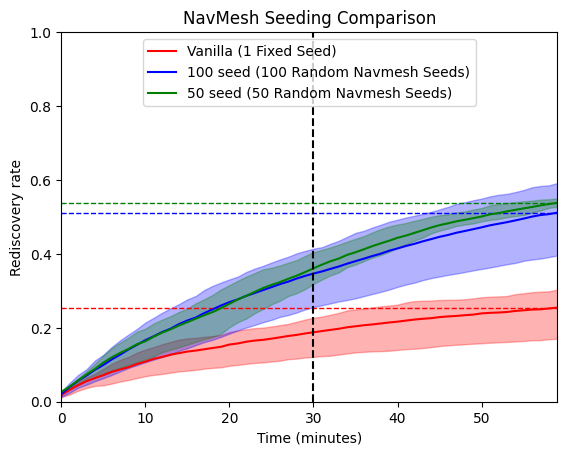

In [8]:
selected_index = [(8, "Vanilla (1 Fixed Seed)", 'red'),
                  (2, "100 seed (100 Random Navmesh Seeds)", 'blue'),
                  (5, "50 seed (50 Random Navmesh Seeds)", 'green')]
print(new_keys[8])
for i, label, color in selected_index:
    plt.fill_between(TimeLine2, RRD[new_keys[i]][2], RRD[new_keys[i]][3] , color = color, alpha = 0.3)
    plt.plot(TimeLine2, RRD[new_keys[i]][0], color = color, label = label)
    #plt.errorbar(TimeLine2, RRD[new_keys[i]][0], yerr=RRD[new_keys[i]][1], ecolor = color, mfc=color, color = color, capsize=1, marker='o', markersize=1,label=label) #capsize is how long the upper lower bars are. 
    plt.axhline(RRD[new_keys[i]][0][-1], linestyle = "dashed", linewidth = 1, color = color)
  
plt.axvline(30,linestyle = "dashed", color = 'black')
plt.xlabel('Time (minutes)')
plt.ylabel('Rediscovery rate')
plt.title('NavMesh Seeding Comparison')
plt.legend(loc='upper center')  # Adjust ncol for number of columns in legend
plt.ylim(0,1)
plt.xlim(0,59)
plt.savefig("Navmesh Seeding Comparison.pdf", format='pdf')
plt.show()   

# Time Dilation Comparison


Vanilla10TimeDilation\Vanilla10TD


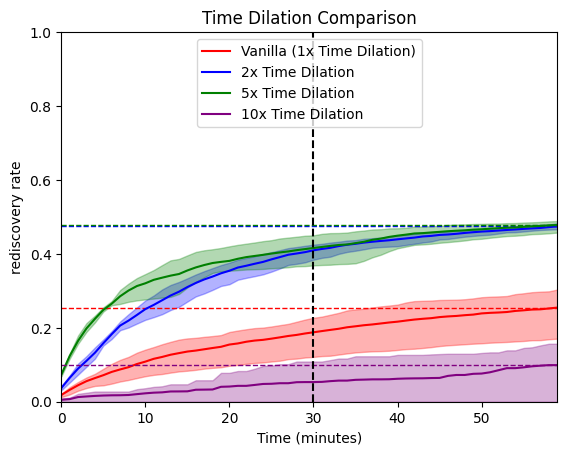

In [9]:
selected_index = [(8, "Vanilla (1x Time Dilation)", 'red'),
                  (4, "2x Time Dilation", 'blue'),
                  (6, "5x Time Dilation", 'green'),
                  (3, "10x Time Dilation", 'purple')]
print(new_keys[3])
for i, label, color in selected_index:
    plt.fill_between(TimeLine2, RRD[new_keys[i]][2], RRD[new_keys[i]][3] , color = color, alpha = 0.3)
    plt.plot(TimeLine2, RRD[new_keys[i]][0], color = color, label = label)
    #plt.errorbar(TimeLine2, RRD[new_keys[i]][0], yerr=RRD[new_keys[i]][1], ecolor = color, mfc=color, color = color, capsize=1, marker='o', markersize=1,label=label) #capsize is how long the upper lower bars are. 
    plt.axhline(RRD[new_keys[i]][0][-1], linestyle = "dashed", linewidth = 1, color = color)
  
plt.axvline(30,linestyle = "dashed", color = 'black')
plt.xlabel('Time (minutes)')
plt.ylabel('rediscovery rate')
plt.title('Time Dilation Comparison')
plt.legend(loc='upper center')  # Adjust ncol for number of columns in legend
plt.ylim(0,1)
plt.xlim(0,59)
plt.savefig("Time Dilation Comparison.pdf", format='pdf')
plt.show()  

# Input Strategy Comparison


VanillaGoExplore2\Instance_12332_true_1_0_V_1.0


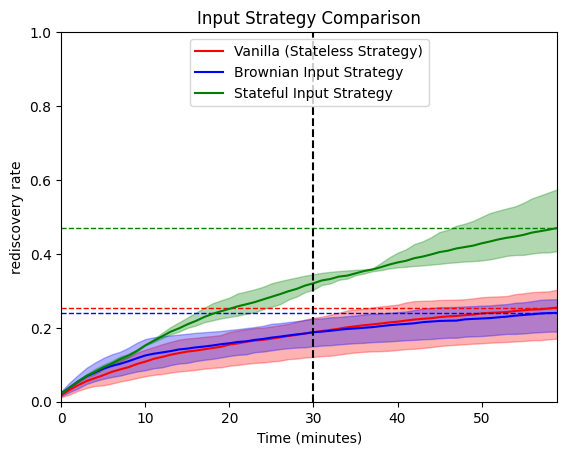

In [10]:
selected_index = [(8, "Vanilla (Stateless Strategy)", 'red'),
                  (7, "Brownian Input Strategy", 'blue'),
                  (10, "Stateful Input Strategy ", 'green')]
print(new_keys[9])
for i, label, color in selected_index:
    plt.fill_between(TimeLine2, RRD[new_keys[i]][2], RRD[new_keys[i]][3] , color = color, alpha = 0.3)
    plt.plot(TimeLine2, RRD[new_keys[i]][0], color = color, label = label)
    #plt.errorbar(TimeLine2, RRD[new_keys[i]][0], yerr=RRD[new_keys[i]][1], ecolor = color, mfc=color, color = color, capsize=1, marker='o', markersize=1,label=label) #capsize is how long the upper lower bars are. 
    plt.axhline(RRD[new_keys[i]][0][-1], linestyle = "dashed", linewidth = 1, color = color)
  
plt.axvline(30,linestyle = "dashed", color = 'black')
plt.xlabel('Time (minutes)')
plt.ylabel('rediscovery rate')
plt.title('Input Strategy Comparison')
plt.legend(loc='upper center')  # Adjust ncol for number of columns in legend
plt.ylim(0,1)
plt.xlim(0,59)
plt.savefig("Input Strategy Comparison.pdf", format='pdf')
plt.show() 

In [12]:
print(FCRR.keys())
keys = list(FCRR.keys())
print(len(keys))
BC = {}


stacked = np.stack([np.array(FCRR[keys[0]]), np.array(FCRR[keys[1]]),np.array(FCRR[keys[2]])])
max_vals = np.max(stacked, axis=0)
min_vals = np.min(stacked, axis=0)
mean_vals = np.mean(stacked, axis=0)

upper_error = max_vals - mean_vals
lower_error = mean_vals - min_vals
errors = [lower_error, upper_error]

BC[keys[0]] = [mean_vals, errors,  min_vals, max_vals]
    
keys = list(BC.keys())
print(keys)


keys2 = list(Vanilla2.keys())
BC2 = {}
stacked = np.stack([np.array(Vanilla2[keys2[0]]), np.array(Vanilla2[keys2[1]]),np.array(Vanilla2[keys2[2]])])
max_vals = np.max(stacked, axis=0)
min_vals = np.min(stacked, axis=0)
mean_vals = np.mean(stacked, axis=0)

upper_error = max_vals - mean_vals
lower_error = mean_vals - min_vals
errors = [lower_error, upper_error]

BC2[keys[0]] = [mean_vals, errors,  min_vals, max_vals]
    
keys2 = list(BC2.keys())
print(keys)

dict_keys(['BestCombination2\\Instance_14768_true_5_100_S_1.0', 'BestCombination2\\Instance_43464_true_5_100_S_1.0', 'BestCombination2\\Instance_49280_true_5_100_S_1.0'])
3
['BestCombination2\\Instance_14768_true_5_100_S_1.0']
['BestCombination2\\Instance_14768_true_5_100_S_1.0']


# Best Combination Comparison


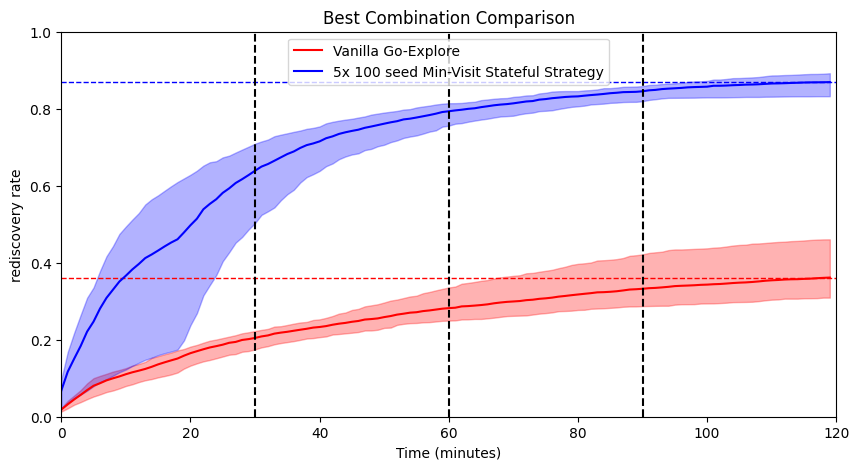

In [14]:
selected_index = [(8, "Vanilla Go-Explore", 'red'),
                  (1, "5x 100 seed Min-Visit Stateful Strategy", 'blue'),]

plt.figure(figsize = (10,5)) 
plt.fill_between(TimeLine3, BC2[keys2[0]][2], BC2[keys2[0]][3] , color = 'red', alpha = 0.3)
plt.plot(TimeLine3, BC2[keys2[0]][0], color = 'red', label = "Vanilla Go-Explore")
#plt.errorbar(TimeLine2, RRD[new_keys[i]][0], yerr=RRD[new_keys[i]][1], ecolor = color, mfc=color, color = color, capsize=1, marker='o', markersize=1,label=label) #capsize is how long the upper lower bars are. 
plt.axhline(BC2[keys2[0]][0][-1], linestyle = "dashed", linewidth = 1, color = 'red')

plt.fill_between(TimeLine3, BC[keys[0]][2], BC[keys[0]][3] , color = 'blue', alpha = 0.3)
plt.plot(TimeLine3, BC[keys[0]][0], color = 'blue', label = "5x 100 seed Min-Visit Stateful Strategy")
#plt.errorbar(TimeLine2, RRD[new_keys[i]][0], yerr=RRD[new_keys[i]][1], ecolor = color, mfc=color, color = color, capsize=1, marker='o', markersize=1,label=label) #capsize is how long the upper lower bars are. 
plt.axhline(BC[keys[0]][0][-1], linestyle = "dashed", linewidth = 1, color = 'blue')


plt.axvline(30,linestyle = "dashed", color = 'black')
plt.axvline(60,linestyle = "dashed", color = 'black')
plt.axvline(90,linestyle = "dashed", color = 'black')
plt.xlabel('Time (minutes)')
plt.ylabel('rediscovery rate')
plt.title('Best Combination Comparison')
plt.legend(loc='upper center')  # Adjust ncol for number of columns in legend
plt.ylim(0,1)
plt.xlim(0,120)
plt.savefig("Best Combination Comparison.pdf", format = 'pdf')
plt.show() 